# Beam Size Tests

**Scott Prahl**

**June 2020, Version 4**

These are all artificial tests.  A perfect astigmatic Gaussian beam is generated and then noise (and/or and offset) is added to the entire image.  Examples are shown in which the default algorithm works perfectly and also fails spectacularly.

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import laserbeamsize as lbs

def side_by_side_plot(h,v,xc,yc,dx,dy,phi,noise=0,offset=0):
    test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi,noise=noise)
    xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test)

    plt.subplots(1,2,figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(test,cmap='gray')
    plt.plot(xc,yc,'ob',markersize=2)
    plt.title('Original (%d,%d), dx=%.0f, dy=%.0f, $\phi$=%.0f°' % (xc,yc,dx,dy,np.degrees(phi)))

    plt.subplot(1,2,2)
    plt.imshow(test,cmap='gray')
    xp,yp = lbs.rotated_rect_arrays(xc_found, yc_found, dx_found, dy_found, phi_found)
    plt.plot(xp,yp,':y')
    plt.plot(xc_found,yc_found,'ob',markersize=2)
    plt.title('Found (%d,%d), dx=%.0f, dy=%.0f, $\phi$=%.0f°' % (xc_found,yc_found,dx_found,dy_found,np.degrees(phi_found)))

## Integration Area

ISO 11146-3 states::

> All integrations ... are performed on a rectangular integration area which is centred to the beam centroid, defined by the spatial first order moments, orientated parallel to the principal axes of the power density distribution, and sized three times the beam widths $d_{\sigma x}$ and $d_{\sigma y}$...

This turned out to be surprisingly fiddly (most likely because masked numpy arrays did't work as I expected).  In the pictures that follow, the dotted rectangle shows the final integration area.

## Algorithm Overview

This shows the effect of background removal, then rectangle masking, then locating the first 

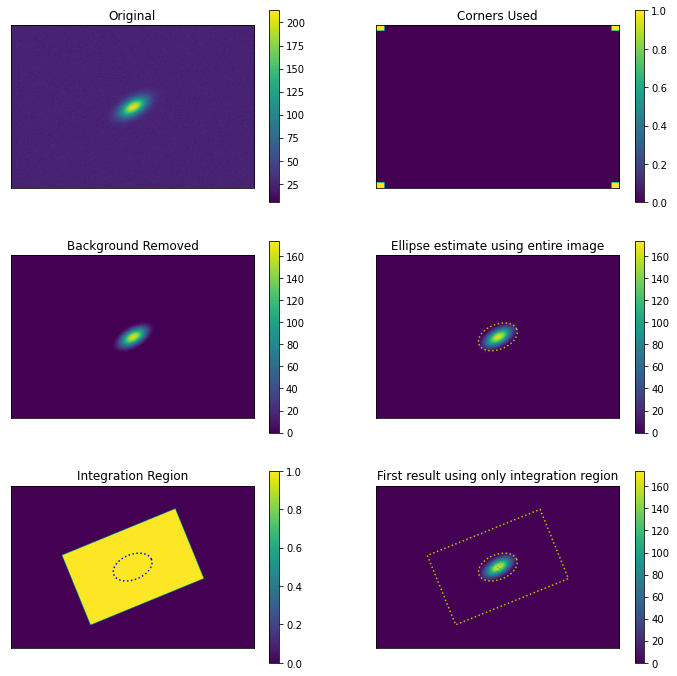

In [2]:
xc=300
yc=200
dx=100
dy=50
phi=np.radians(30)
h=600
v=400
max_value=1023
noise = 25

# generate test image
test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi,noise=noise)

plt.subplots(3,2,figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(test)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Original')

# corners
corners = lbs.corner_mask(test)
plt.subplot(3,2,2)
plt.imshow(corners)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Corners Used')

# remove background
back, sigma = lbs.corner_background(test)
offset = int(back+3*sigma)
zeroed = lbs.subtract_threshold(test, offset)

plt.subplot(3,2,3)
plt.imshow(zeroed)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Background Removed')

# first guess at beam parameters
xc, yc, dx, dy, phi = lbs.basic_beam_size(zeroed)

plt.subplot(3,2,4)
plt.imshow(zeroed)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.ellipse_arrays(xc, yc, dx, dy, phi)
plt.plot(xp,yp,':y')
plt.title('Ellipse estimate using entire image')

mask = lbs.rotated_rect_mask(zeroed, xc, yc, dx, dy, phi)

plt.subplot(3,2,5)
plt.imshow(mask)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.ellipse_arrays(xc, yc, dx, dy, phi)
plt.plot(xp,yp,':b')
plt.title('Integration Region')

masked_image = np.copy(zeroed)
masked_image[mask < 1] = 0       # zero all values outside mask

plt.subplot(3,2,6)
plt.imshow(masked_image)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.rotated_rect_arrays(xc, yc, dx, dy, phi)
plt.plot(xp,yp,':y')
xp,yp = lbs.ellipse_arrays(xc, yc, dx, dy, phi)
plt.plot(xp,yp,':y')
plt.title('First result using only integration region')

plt.show()

## Integration Area Tests

### Test 1 Centered, Horizontal, away from edges

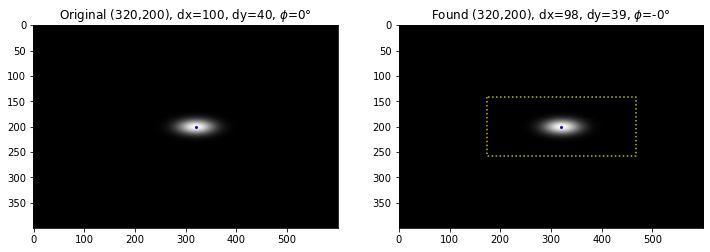

In [3]:
xc=320
yc=200
dx=100
dy=40
phi=np.radians(0)
h=600
v=400

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

### Test 2 Corner, Horizontal

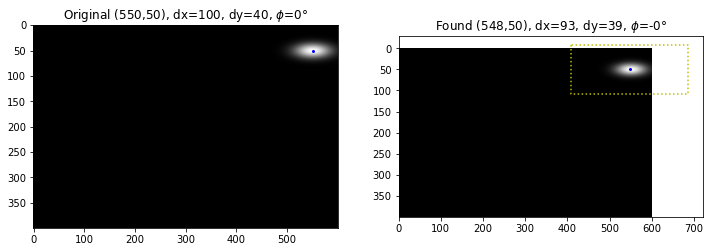

In [4]:
xc=550
yc=50

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

### Test 3 Center, tilted 30°

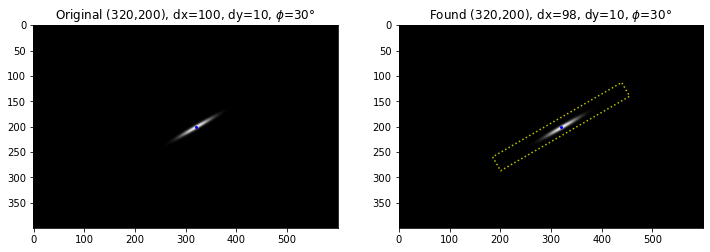

In [5]:
xc=320
yc=200
dx=100
dy=10
phi=np.radians(30)

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

### Test 4 Corner, tilted 30°

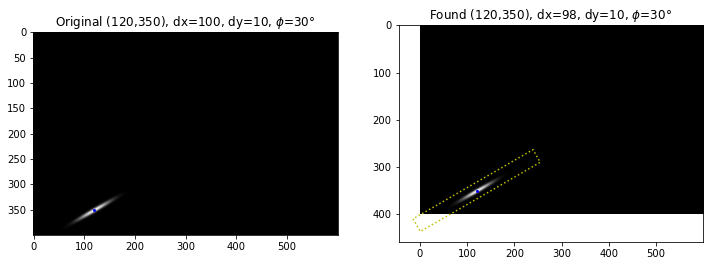

In [6]:
xc=120
yc=350

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

### Test 5 Center, tilted 70°

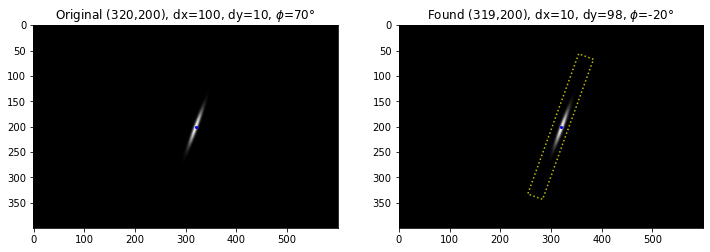

In [7]:
xc=320
yc=200
dx=100
dy=10
phi=np.radians(70)

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

## Tests with Poisson noise

### Test 1. Simple, noise-free rotated elliptical beam

In this and all rest of the test functions, the maximum value in the test array is 256.

No gaussian noise, works fine!

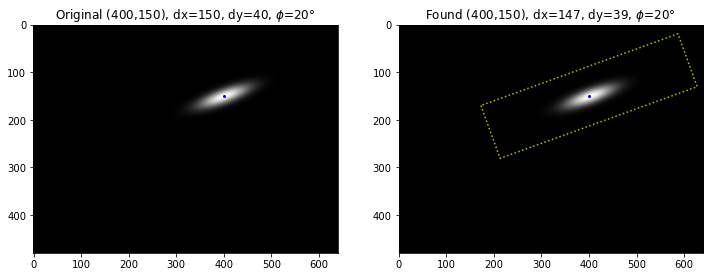

In [8]:
xc=400
yc=150
dx=150
dy=40
phi=np.radians(20)
h=640
v=480

side_by_side_plot(h,v,xc,yc,dx,dy,phi,noise=0)
plt.show()

### Test 2. Set noise to 5%

Mostly works.  Widths are a bit off.

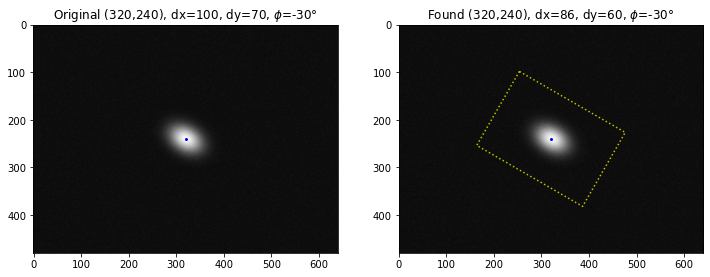

In [9]:
xc=320
yc=240
dx=100
dy=70
phi=np.radians(-30)
h=640
v=480

side_by_side_plot(h,v,xc,yc,dx,dy,phi,noise=0.05*255)
plt.show()

### Test 3: Rotated elliptical beam with 4% noise

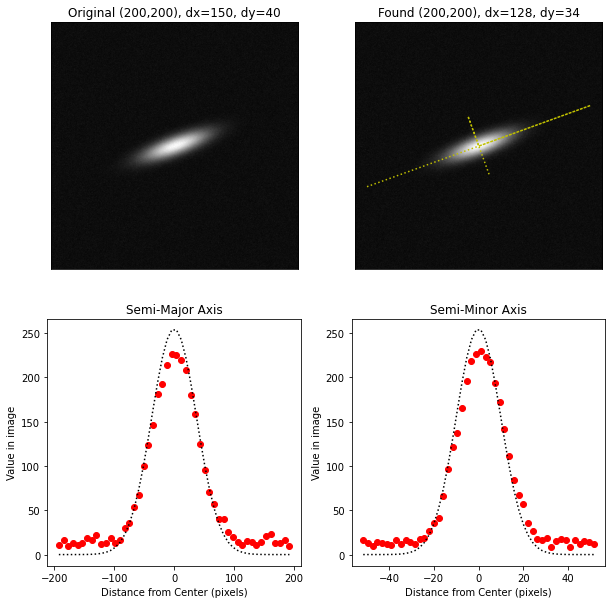

In [10]:
xc=200
yc=200
dx=150
dy=40
phi=np.radians(20)
h=400
v=400
max_value = 255
noise = 0.05 * max_value

test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi,noise=noise,max_value=max_value)
xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test)

plt.subplots(2,2,figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(test,cmap='gray')
plt.title('Original (%d,%d), dx=%d, dy=%d' % (xc,yc,dx,dy))
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,2)
plt.imshow(test,cmap='gray')
xp,yp = lbs.axes_arrays(xc_found, yc_found, dx_found, dy_found, phi_found)
plt.plot(xp,yp,':y')
plt.title('Found (%d,%d), dx=%d, dy=%d' % (xc_found, yc_found,dx_found, dy_found))
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
x,y,z,s = lbs.major_axis_arrays(test,xc_found, yc_found, dx_found, dy_found, phi_found)
plt.plot(s,z,'or', label='data')
#plt.axvline(0.5*dx_found,color='blue',linestyle=':')
#plt.axvline(-0.5*dx_found,color='blue',linestyle=':')

plt.plot(s,max_value*np.exp(-2*s**2/(dx/2)**2), ':k', label='fitted')
#plt.axhline(max_value*np.exp(-2))        
plt.xlabel('Distance from Center (pixels)')
plt.ylabel('Value in image')
plt.title('Semi-Major Axis')


plt.subplot(2,2,4)
x,y,z,s = lbs.minor_axis_arrays(test,xc_found, yc_found, dx_found, dy_found, phi_found)

plt.plot(s,z,'or', label='data')
#plt.axvline(+0.5*dy_found,color='blue',linestyle=':')
#plt.axvline(-0.5*dy_found,color='blue',linestyle=':')

plt.plot(s,max_value*np.exp(-2*s**2/(dy/2)**2), ':k', label='fitted')
#plt.axhline(max_value*np.exp(-2))        
plt.xlabel('Distance from Center (pixels)')
plt.ylabel('Value in image')
plt.title('Semi-Minor Axis')


plt.show()